In [30]:
import os
import warnings
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error , root_mean_squared_error

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss , MAE

from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger

In [31]:
DATA_CSV = Path("D:\PSU/241-353/Mini_Project/data/augmented_data.csv")  # ensure this CSV is in the same folder when running
DATE_COL = "วันที่"
TARGET_COL = "รถไฟฟ้าสายสีแดง"

# Exogenous covariates (adjust names if different in your CSV)
DAY_TYPE_COL = "day_type"         # categorical
RAIN_COL     = "rain_average"     # real
ARL_COL      = "รถไฟฟ้า ARL"      # real
PURPLE_COL   = "รถไฟฟ้าสายสีม่วง" # real
BTS_COL      = "รถไฟฟ้าสายสีน้ำเงิน"      # real

# Model / dataset params
GROUP_ID = "series_id"
MAX_PRED_LEN = 30
MAX_ENC_LEN  = 120
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_EVAL  = 128
EPOCHS = 200
LR = 3e-4
RANDOM_SEED = 2025

In [32]:
PLOTS_DIR = Path("tft_red_outputs")
PLOTS_DIR.mkdir(exist_ok=True, parents=True)
csv_logger = CSVLogger(save_dir=str(PLOTS_DIR), name="logs")

In [33]:
def _safe_interp_fill(s: pd.Series) -> pd.Series:
    """Interpolate then back/forward fill for numeric series."""
    try:
        s = pd.to_numeric(s, errors="coerce")
    except Exception:
        pass
    s = s.interpolate(limit_direction="both")
    s = s.bfill().ffill()
    return s


In [34]:

pl.seed_everything(RANDOM_SEED, workers=True)
warnings.filterwarnings("ignore")

# 1) Load data
if not DATA_CSV.exists():
    raise FileNotFoundError(f"CSV not found: {DATA_CSV.resolve()}")
df = pd.read_csv(DATA_CSV)
df = df[df[DATE_COL] >= '2021-08-02']  # ใช้ข้อมูลหลังจากวันที่ 2021-08-02

# Basic checks
for c in [DATE_COL, TARGET_COL]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in CSV. Please edit config at top of the file.")

# 2) Feature engineering
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df[GROUP_ID] = "red"
df["time_idx"] = (df[DATE_COL] - df[DATE_COL].min()).dt.days.astype(int)

# Optional: build is_weekend from date (Saturday=5, Sunday=6)
# df["is_weekend"] = df[DATE_COL].dt.weekday.isin([5, 6]).astype(int)
df["dow"] = df[DATE_COL].dt.weekday.astype("category")
# Cast categorical for day_type if present
if DAY_TYPE_COL in df.columns:
    df[DAY_TYPE_COL] = df[DAY_TYPE_COL].astype(str).astype("category")

if "dow" in df.columns:
    df["dow"] = df["dow"].astype(str).astype("category")

# Fill numeric covariates
for col in [RAIN_COL, ARL_COL, PURPLE_COL, BTS_COL, TARGET_COL]:
    if col in df.columns:
        df[col] = _safe_interp_fill(df[col])

# 3) Define feature lists (no leakage: do NOT include target in features)
time_varying_known_categoricals = [c for c in [DAY_TYPE_COL, "dow"] if c in df.columns]
time_varying_known_reals = ["time_idx"]

categorical_encoders = {}
if DAY_TYPE_COL in df.columns:
    categorical_encoders[DAY_TYPE_COL] = NaNLabelEncoder(add_nan=True)  # เผื่อมีค่าว่าง/ไม่รู้ล่วงหน้า
if "dow" in df.columns:
    categorical_encoders["dow"] = NaNLabelEncoder(add_nan=False)     

time_varying_unknown_reals = []
for col in [ARL_COL, BTS_COL, PURPLE_COL, RAIN_COL]:
    if col in df.columns:
        time_varying_unknown_reals.append(col)

# 4) Split by time for training/validation
max_time_idx = int(df["time_idx"].max())
training_cutoff = max_time_idx - MAX_PRED_LEN


Seed set to 2025


In [35]:
# Training dataset
training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[GROUP_ID],
    max_encoder_length=MAX_ENC_LEN,
    max_prediction_length=MAX_PRED_LEN,
    target_normalizer=GroupNormalizer(groups=[GROUP_ID], transformation=None),  # keep target in original scale
    static_categoricals=[GROUP_ID],
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals + [TARGET_COL],  # include target as unknown-real (historical known to encoder, masked in decoder)
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=True,
    categorical_encoders=categorical_encoders
)

# Validation FUTURE (predict next 30 days) -> no y_true
val_future = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)



In [36]:
# Validation HISTORICAL window that still has y_true (backtest)
start_idx = int(training_cutoff - MAX_ENC_LEN - MAX_PRED_LEN + 1)
end_idx   = int(training_cutoff)
mask = (df["time_idx"] >= start_idx) & (df["time_idx"] <= end_idx)
df_val_hist = df.loc[mask].copy()
needed = MAX_ENC_LEN + MAX_PRED_LEN
if len(df_val_hist) < needed:
    # fallback: shrink encoder length to fit
    shrink = needed - len(df_val_hist) + 1
    enc_len = max(30, MAX_ENC_LEN - shrink)  # don't go below 30
    print(f"[WARN] val_hist window too short ({len(df_val_hist)} rows). Shrinking encoder length to {enc_len}.")
    enc_len_use = enc_len
else:
    enc_len_use = MAX_ENC_LEN


In [37]:
# 5) Dataloaders
train_loader = training.to_dataloader(train=True,  batch_size=BATCH_SIZE_TRAIN, num_workers=0)
val_loader   = val_future.to_dataloader(train=False, batch_size=BATCH_SIZE_EVAL, num_workers=0)


In [38]:
# 6) Define model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=42,
    attention_head_size=2,
    hidden_continuous_size=42,
    dropout=0.05,
    loss=MAE(),
    log_interval=50,
    optimizer="adam",
    reduce_on_plateau_patience=4,
)

# 7) Train
ckpt_dir = PLOTS_DIR / "ckpts"
ckpt_dir.mkdir(exist_ok=True, parents=True)

callbacks = [
    EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, mode="min"),
    ModelCheckpoint(dirpath=str(ckpt_dir), filename="best", save_top_k=1, monitor="val_loss", mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
]

trainer = pl.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    gradient_clip_val=0.1,
    callbacks=callbacks,
    log_every_n_steps=10,
    default_root_dir=str(PLOTS_DIR),
    logger=csv_logger,  
)
trainer.fit(tft, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Load best model
best_path = callbacks[1].best_model_path if hasattr(callbacks[1], "best_model_path") else None
if best_path and os.path.exists(best_path):
    tft = TemporalFusionTransformer.load_from_checkpoint(best_path)

# 9) Forecast next 30 days (future)
pred_future = tft.predict(val_loader)  # future → no y_true
if isinstance(pred_future, list):
    y_pred_future = torch.cat([p for p in pred_future], dim=0)
else:
    y_pred_future = pred_future

# shape should be [1, 30] for single-series
yhat = y_pred_future.detach().cpu().numpy().reshape(-1)

last_date = df[DATE_COL].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=MAX_PRED_LEN, freq="D")
df_forecast = pd.DataFrame({"date": future_dates, "forecast_red": yhat})
out_csv = PLOTS_DIR / "tft_red_30day_forecast.csv"
df_forecast.to_csv(out_csv, index=False)
print(f"[Forecast] 30-day forecast saved to: {out_csv.resolve()}")

# quick preview plot
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL].tail(120), df[TARGET_COL].tail(120), label="History (last 120d)")
plt.plot(df_forecast["date"], df_forecast["forecast_red"], label="Forecast (30d)")
plt.title("MRT red: History vs 30-day Forecast")
plt.xlabel("Date")
plt.ylabel("Ridership (red)")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS_DIR / "history_vs_forecast_30d.png", dpi=150)
plt.close()

print("[Done] Outputs in:", PLOTS_DIR.resolve())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 48     | train
3  | prescalers                         | ModuleDict                      | 840    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 22.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 55.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 15.7 K | train
7  | static_cont

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[Forecast] 30-day forecast saved to: D:\PSU\241-353\Mini_Project\ML\TFT\RED\tft_red_outputs\tft_red_30day_forecast.csv
[Done] Outputs in: D:\PSU\241-353\Mini_Project\ML\TFT\RED\tft_red_outputs


In [39]:
training_cutoff = int(df["time_idx"].max()) - MAX_PRED_LEN
start_idx = int(training_cutoff - MAX_ENC_LEN - MAX_PRED_LEN + 1)
end_idx   = int(training_cutoff)

df_val30 = df[(df["time_idx"] >= start_idx) & (df["time_idx"] <= end_idx)].copy()

# 2) ใช้ schema เดิมจาก training → มี y_true แน่นอน
val30_ds = TimeSeriesDataSet.from_dataset(training, df_val30, predict=False, stop_randomization=True)
val30_loader = val30_ds.to_dataloader(train=False, batch_size=128, num_workers=0)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


✅ Saved metrics: D:\PSU\241-353\Mini_Project\ML\TFT\RED\tft_red_outputs\val30_metrics.csv
✅ Saved CSV: D:\PSU\241-353\Mini_Project\ML\TFT\RED\tft_red_outputs\val30_actual_vs_pred.csv


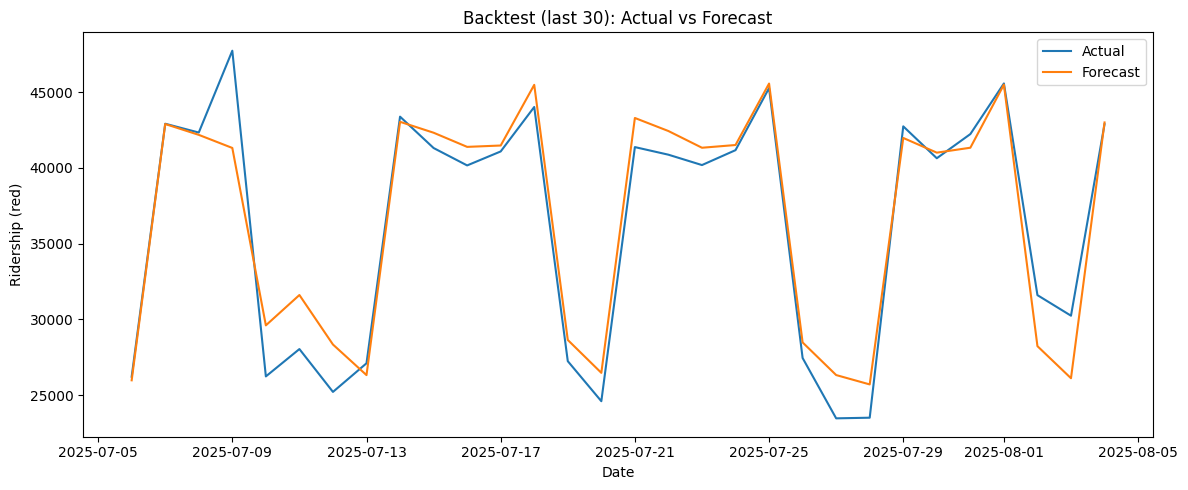

✅ Saved PNG: D:\PSU\241-353\Mini_Project\ML\TFT\RED\tft_red_outputs\backtest_last_true_vs_pred.png


In [40]:
from pathlib import Path

PLOTS_DIR = Path("tft_red_outputs"); PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# 1) y_pred from model (val30_loader must come from predict=False window)
preds = tft.predict(val30_loader)
y_pred = preds if torch.is_tensor(preds) else torch.cat(preds, dim=0)

# If quantiles [B, T, Q] → pick median q=0.5
if y_pred.ndim == 3:
    try:
        qs = list(getattr(tft.loss, "quantiles", [0.1, 0.5, 0.9]))
        q_idx = qs.index(0.5) if 0.5 in qs else 1
    except Exception:
        q_idx = 1
    y_pred = y_pred[..., q_idx]

# 2) y_true: handle (x,y) tuples, dicts, or nested tuples/lists
def extract_target_from_batch(batch):
    # case A: tuple/list like (x, y) or (x, y, index)
    if isinstance(batch, (tuple, list)) and len(batch) >= 2:
        x, y = batch[0], batch[1]
        # y is already a tensor
        if isinstance(y, torch.Tensor):
            return y
        # y is tuple/list -> find first tensor inside
        if isinstance(y, (tuple, list)):
            for item in y:
                if isinstance(item, torch.Tensor):
                    return item
        # y is dict with known keys
        if isinstance(y, dict):
            for k in ("decoder_target", "target", "y"):
                if k in y and isinstance(y[k], torch.Tensor):
                    return y[k]
        # fallback: try x dict
        if isinstance(x, dict):
            if "decoder_target" in x and isinstance(x["decoder_target"], torch.Tensor):
                return x["decoder_target"]
    # case B: dict batch
    if isinstance(batch, dict):
        for k in ("decoder_target", "target", "y"):
            if k in batch and isinstance(batch[k], torch.Tensor):
                return batch[k]
    raise TypeError(f"Cannot extract target from batch of type {type(batch)}")

ys = []
for b in val30_loader:
    y_t = extract_target_from_batch(b)
    ys.append(y_t)

# now cat tensors
y_true = torch.cat(ys, dim=0)

# 3) metrics + plot
y_p = y_pred.detach().cpu().numpy().reshape(-1)
y_t = y_true.detach().cpu().numpy().reshape(-1)

mae  = mean_absolute_error(y_t, y_p)
rmse = root_mean_squared_error(y_t, y_p)
mape = mean_absolute_percentage_error(y_t, y_p) * 100.0
smape = (np.mean(np.abs(y_p - y_t) / ((np.abs(y_t)+np.abs(y_p))/2.0 + 1e-9))) * 100.0
metrics_df = pd.DataFrame([{
    "MAE": float(mae),
    "RMSE": float(rmse),
    "MAPE_pct": float(mape),
    "sMAPE_pct": float(smape),
    "n_points": int(len(y_t)),
}])

metrics_path = PLOTS_DIR / "val30_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Saved metrics: {metrics_path.resolve()}")

idx_to_date = dict(zip(df["time_idx"].astype(int).tolist(),
                       pd.to_datetime(df[DATE_COL]).tolist()))

# 1) ดึง y_true และ (ถ้ามี) decoder_time_idx ให้ครบในลูปเดียวกัน
ys, t_idx_batches = [], []
for b in val30_loader:  # val30_loader ต้องมาจาก TimeSeriesDataSet(..., predict=False)
    # --- ดึง y_true ตามโครงสร้าง batch ---
    if isinstance(b, (tuple, list)) and len(b) >= 2:
        x, y = b[0], b[1]
        # y เป็น tensor ตรง ๆ
        if isinstance(y, torch.Tensor):
            ys.append(y)
        # y เป็น tuple/list → หาตัว tensor ตัวแรก
        elif isinstance(y, (tuple, list)):
            found = None
            for item in y:
                if isinstance(item, torch.Tensor):
                    found = item; break
            if found is None:
                raise TypeError("Cannot find tensor target inside (tuple/list) y")
            ys.append(found)
        # y เป็น dict
        elif isinstance(y, dict):
            for k in ("decoder_target", "target", "y"):
                if k in y and isinstance(y[k], torch.Tensor):
                    ys.append(y[k]); break
            else:
                raise TypeError("Cannot find tensor target inside dict y")
        else:
            raise TypeError(f"Unexpected y type: {type(y)}")
        # --- เก็บ decoder_time_idx ถ้ามีอยู่ใน x ---
        if isinstance(x, dict) and "decoder_time_idx" in x and isinstance(x["decoder_time_idx"], torch.Tensor):
            t_idx_batches.append(x["decoder_time_idx"])
    elif isinstance(b, dict):
        # บางเวอร์ชัน batch เป็น dict เลย
        for k in ("decoder_target", "target", "y"):
            if k in b and isinstance(b[k], torch.Tensor):
                ys.append(b[k]); break
        # decoder_time_idx
        if "decoder_time_idx" in b and isinstance(b["decoder_time_idx"], torch.Tensor):
            t_idx_batches.append(b["decoder_time_idx"])
    else:
        raise TypeError(f"Unexpected batch type: {type(b)}")

y_true = torch.cat(ys, dim=0)                       # [B, T]
y_t = y_true.detach().cpu().numpy().reshape(-1)     # flatten

# 2) สร้างลิสต์วันที่ตามลำดับเดียวกับ y_t / y_p
if len(t_idx_batches) > 0:
    dec_time_idx = torch.cat(t_idx_batches, dim=0)          # [B, T]
    time_idx_flat = dec_time_idx.detach().cpu().numpy().reshape(-1).tolist()
    dates = [idx_to_date[int(i)] for i in time_idx_flat]     # ยาวเท่า y_t
else:
    # Fallback: คำนวณจาก cutoff (ในกรณี x ไม่มี decoder_time_idx)
    MAX_PRED_LEN = getattr(training, "max_prediction_length", len(y_t))
    training_cutoff = int(df["time_idx"].max()) - MAX_PRED_LEN
    dec_start_idx = training_cutoff - MAX_PRED_LEN + 1
    # ยาวเท่าจำนวนจุดที่เรามีจริง
    dates = [idx_to_date[i] for i in range(dec_start_idx, dec_start_idx + len(y_t))]

# 3) ทำให้ y_pred ยาวเท่ากัน (ป้องกัน mismatch เผื่อ flatten แล้วต่างกัน)
n = min(len(y_t), len(y_p), len(dates))
dates = pd.to_datetime(dates[:n])
y_t = y_t[:n]
y_p = y_p[:n]

# 4) บันทึก CSV: date, actual, forecast
outdir = PLOTS_DIR
df_eval = pd.DataFrame({"date": dates, "actual": y_t, "forecast": y_p})
csv_path = outdir / "val30_actual_vs_pred.csv"
df_eval.to_csv(csv_path, index=False)
print(f"✅ Saved CSV: {csv_path.resolve()}")

# 5) วาดกราฟโดยใช้วันที่บนแกน X
plt.figure(figsize=(12,5))
plt.plot(df_eval["date"], df_eval["actual"], label="Actual")
plt.plot(df_eval["date"], df_eval["forecast"], label="Forecast")
plt.title("Backtest (last 30): Actual vs Forecast")
plt.xlabel("Date"); plt.ylabel("Ridership (red)")
plt.legend(); plt.tight_layout(); plt.show()

# และเซฟรูปด้วย
png_path = outdir / "backtest_last_true_vs_pred.png"
plt.figure(figsize=(12,5))
plt.plot(df_eval["date"], df_eval["actual"], label="Actual")
plt.plot(df_eval["date"], df_eval["forecast"], label="Forecast")
plt.title("Backtest (last 30): Actual vs Forecast")
plt.xlabel("Date"); plt.ylabel("Ridership (red)")
plt.legend(); plt.tight_layout(); plt.savefig(png_path, dpi=150); plt.close()
print(f"✅ Saved PNG: {png_path.resolve()}")